In [1]:
# see https://github.com/JustGlowing/minisom/blob/master/examples/HexagonalTopology.ipynb
# maybe look at this??? https://github.com/JustGlowing/minisom/blob/master/examples/DemocracyIndex.ipynb
from minisom import MiniSom

import pandas as pd
import numpy as np
import anndata as ad

import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

# display matplotlib plots in notebook
%matplotlib inline
# display bokeh plot in notebook

In [2]:
input_dir_w6 = "/home/users/kzlin/kzlinlab/projects/scContrastiveLearn/out/kevin/Writeup6/"
# Load dataset

train_embeddings = np.load(input_dir_w6+'scBaseEncoderFeat_Z_bs250_tau0.5.npy')
print(train_embeddings.shape)

(41093, 5)


In [3]:
input_dir_w5 = "/home/users/kzlin/kzlinlab/projects/scContrastiveLearn/out/kevin/Writeup5/"

adata_train = ad.read_h5ad(input_dir_w5+'Larry_41093_2000_norm_log_cleaned.h5ad')

# adata_train.obs['Cell type annotation'] = adata_train.obs["cell_type"]
# adata_test.obs['Cell type annotation'] = adata_test.obs["cell_type"]
train_labels = adata_train.obs["clone_id"].to_numpy()
print(train_labels.shape)

(41093,)


In [4]:
# Create a boolean mask based on the condition in adata_train
mask = (adata_train.obs["time_info"] == 2.0)
# Subset adata_train based on the mask
adata_subset = adata_train[mask]

# Subset train_embeddings based on the same mask
train_embeddings_subset = train_embeddings[mask.to_numpy()]

In [5]:
som = MiniSom(15, 15,train_embeddings_subset.shape[1] , sigma=1.5, learning_rate=.7, activation_distance='euclidean',
              topology='hexagonal', neighborhood_function='gaussian', random_seed=10)

som.train(train_embeddings_subset, 100000, verbose=True)

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.13633392490201304


In [6]:
# Get the weights of the SOM after training
weights = som.get_weights()

# Calculate the U-matrix for visualization
umatrix = som.distance_map()

xx, yy = som.get_euclidean_coordinates()

<Axes: >

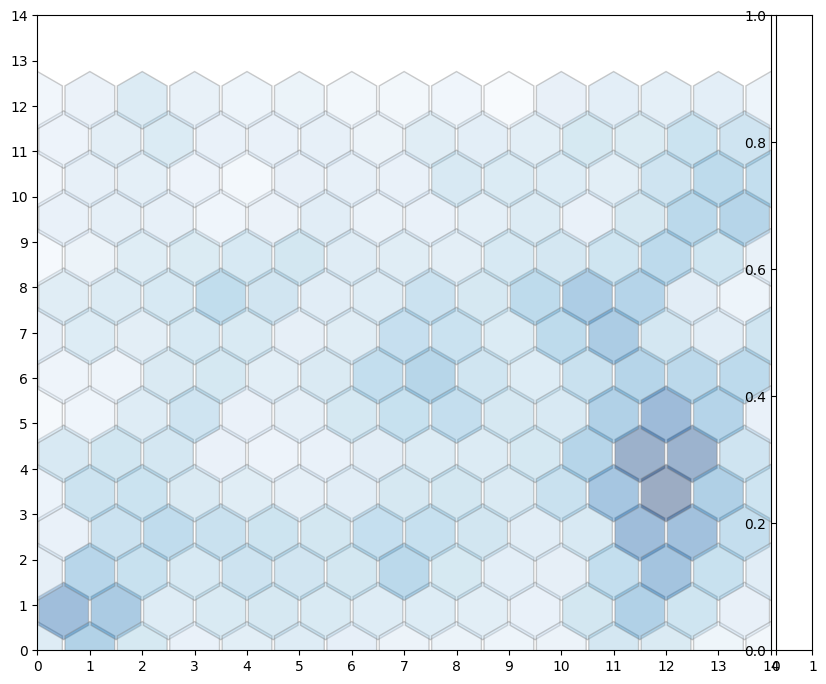

In [7]:
# Create a figure for the hexagonal grid visualization
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# Create a hexagonal grid for the SOM
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        hex = RegularPolygon((xx[(i, j)], wy),
                             numVertices=6, 
                             radius=.95 / np.sqrt(3), 
                             facecolor=cm.Blues(umatrix[i, j]), 
                             alpha=.4, 
                             edgecolor='gray')
        ax.add_patch(hex)

xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange * np.sqrt(3) / 2, yrange)

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
plt.gcf().add_axes(ax_cb)

In [12]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

class SOMClustering:
    def __init__(self, som_weights, topology='hexagonal'):
        self.som_weights = som_weights  # SOM weights (neurons x features)
        self.topology = topology
        self.distances = None  # Distance map to store distances between neighbors
        self.segments = None   # Segment labels for each neuron
        
    def calculate_distance_map(self):
        """Calculates the distance between adjacent neurons."""
        rows, cols = self.som_weights.shape[0], self.som_weights.shape[1]
        distance_map = np.full((rows, cols, 6), np.nan)  # 6 neighbors for hex topology
        
        # Neighboring indices for even and odd rows (hexagonal grid)
        ii_even = [1, 1, 1, 0, -1, 0] 
        jj_even = [1, 0, -1, -1, 0, 1]
        ii_odd = [0, 1, 0, -1, -1, -1]
        jj_odd = [1, 0, -1, -1, 0, 1]
        
        for x in range(rows):
            for y in range(cols):
                w_2 = self.som_weights[x, y]
                neighbors = ii_even if y % 2 == 0 else ii_odd
                jj = jj_even if y % 2 == 0 else jj_odd
                for k, (i, j) in enumerate(zip(neighbors, jj)):
                    if 0 <= x + i < rows and 0 <= y + j < cols:
                        w_1 = self.som_weights[x + i, y + j]
                        distance_map[x, y, k] = np.linalg.norm(w_2 - w_1)
                        
        return distance_map
    
    def merge_segments(self, distance_map, num_segments):
        """Merges segments based on distance until the desired number of segments is reached."""
        rows, cols = self.som_weights.shape[0], self.som_weights.shape[1]
        segment_labels = np.arange(rows * cols).reshape(rows, cols)  # Each neuron starts as its own segment

        # Neighboring indices for even and odd rows
        ii_even = [1, 1, 1, 0, -1, 0] 
        jj_even = [1, 0, -1, -1, 0, 1]
        ii_odd = [0, 1, 0, -1, -1, -1]
        jj_odd = [1, 0, -1, -1, 0, 1]

        while np.unique(segment_labels).size > num_segments:
            min_dist = np.inf
            to_merge = None
            
            for x in range(rows):
                for y in range(cols):
                    for k, dist in enumerate(distance_map[x, y]):
                        if not np.isnan(dist) and dist < min_dist:
                            nx, ny = x + (ii_even[k] if y % 2 == 0 else ii_odd[k]), y + (jj_even[k] if y % 2 == 0 else jj_odd[k])
                            if 0 <= nx < rows and 0 <= ny < cols and segment_labels[x, y] != segment_labels[nx, ny]:
                                min_dist = dist
                                to_merge = ((x, y), (nx, ny))
            
            if to_merge:
                seg1, seg2 = segment_labels[to_merge[0]], segment_labels[to_merge[1]]
                segment_labels[segment_labels == seg2] = seg1  # Merge segments
                
                # Update the distance map for the newly merged segment
                self.update_distances(segment_labels, distance_map)
        
        return segment_labels
    
    def update_distances(self, segment_labels, distance_map):
        """Update the distances between segments after a merge."""
        # Recalculate distances between neurons that are in different segments
        rows, cols = segment_labels.shape

        # Neighboring indices for even and odd rows
        ii_even = [1, 1, 1, 0, -1, 0] 
        jj_even = [1, 0, -1, -1, 0, 1]
        ii_odd = [0, 1, 0, -1, -1, -1]
        jj_odd = [1, 0, -1, -1, 0, 1]
        
        for x in range(rows):
            for y in range(cols):
                for k, dist in enumerate(distance_map[x, y]):
                    if not np.isnan(dist):
                        nx, ny = x + (ii_even[k] if y % 2 == 0 else ii_odd[k]), y + (jj_even[k] if y % 2 == 0 else jj_odd[k])
                        if 0 <= nx < rows and 0 <= ny < cols and segment_labels[x, y] != segment_labels[nx, ny]:
                            distance_map[x, y, k] = np.linalg.norm(self.som_weights[x, y] - self.som_weights[nx, ny])
    
    def fit(self, num_segments=8):
        """Performs the SOM clustering."""
        # Step 1: Calculate the distance map
        distance_map = self.calculate_distance_map()
        
        # Step 2: Merge segments iteratively until num_segments are reached
        self.segments = self.merge_segments(distance_map, num_segments)
        
        return self.segments

In [13]:
# Assume som_weights is a 2D array of neurons (rows, cols, features)
som_clustering = SOMClustering(weights)
segments = som_clustering.fit(num_segments=8)

print(segments)  # Each neuron now has a segment label

[[  0   1 186 186 186 186 186 186 186 186 186 186 186 186 186]
 [ 15 186 186 186 186 186 186 186 186 186 186 186 186 186 186]
 [186 186 186 186 186 186 186 186 186 186 186 186 186 186 186]
 [186 186 186 186 186 186 186 186 186 186 186 186 186 186 186]
 [186 186 186 186 186 186 186 186 186 186 186 186 186 186 186]
 [186 186 186 186 186 186 186 186 186 186 186 186 186 186 186]
 [186 186 186 186 186 186 186 186 186 186 186 186 186 186 186]
 [186 186 186 186 186 186 186 186 186 186 186 186 186 186 186]
 [186 186 186 186 186 186 186 186 186 186 186 186 186 186 186]
 [186 186 186 186 186 186 186 186 186 186 186 186 186 186 186]
 [186 186 186 186 186 186 186 186 186 186 186 186 186 186 186]
 [186 186 186 186 186 170 186 172 172 186 186 186 186 186 186]
 [183 183 182 183 183 183 186 186 186 186 186 186 186 186 186]
 [183 183 183 183 183 183 183 183 186 186 186 186 186 186 186]
 [183 183 183 183 183 183 183 183 186 186 186 186 186 186 186]]
